In [54]:
import cv2
import numpy as np
import os
import os.path as osp
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import clip
from clip_score import TextFeatureFixed, ImageFeatureBoxes, VOC_NEW, VOC_BACKGROUND_CATEGORY
from functools import partial

In [9]:
def ann2box(ann, img, multi_contour_eval=True):
    height, width = ann.shape
    ann[ann > 0] = 255
    contours = cv2.findContours(
        image=ann,
        mode=cv2.RETR_LIST,
        method=cv2.CHAIN_APPROX_SIMPLE)[0]
    if len(contours) == 0:
        return np.asarray([[0, 0, 0, 0]]), 1
    # print(hierarchy)
    print(len(contours))
    img2 = img.copy()
    # for idx, contour in enumerate(contours):
    #     print(idx)
    # color = np.random.randint(0, 255, (3, )).tolist()
    cv2.drawContours(img2, contours, -1, (255, 0, 0), 5)
    plt.imshow(img2[:, :, ::-1])
    plt.show()
    if not multi_contour_eval:
        contours = [max(contours, key=cv2.contourArea)]
    estimated_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x0, y0, x1, y1 = x, y, x + w, y + h
        x1 = min(x1, width - 1)
        y1 = min(y1, height - 1)
        estimated_boxes.append([x0, y0, x1, y1])
    return estimated_boxes

In [44]:
root = '../../data/DiffuseMade10'
img_dir = 'img_dir/train'
ann_dir = 'out_combine/out_ann_dir/tanh2-0.25-4.0-dcrf-0.05-0.95'
# name = '00016518.png'
# name = '00009189.png'
name = '00009844.png'
img_path = osp.join(root, img_dir, name)
ann_path = osp.join(root, ann_dir, name)

img = cv2.imread(img_path, cv2.IMREAD_COLOR)
ann = cv2.imread(ann_path, cv2.IMREAD_GRAYSCALE)

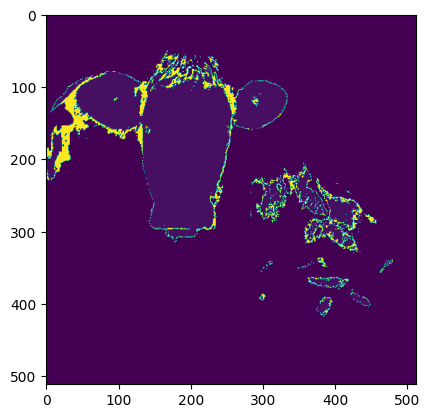

In [45]:
plt.imshow(ann)
plt.show()

183


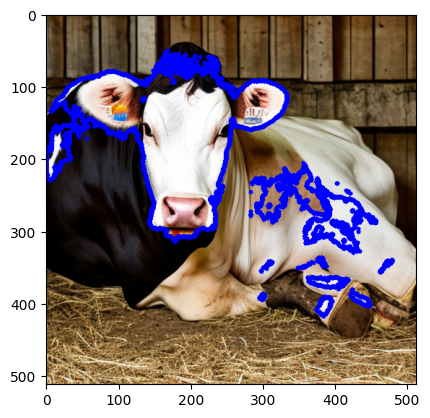

[[385, 391, 388, 394], [374, 391, 397, 419], [295, 387, 304, 396], [421, 385, 449, 405], [423, 381, 425, 383], [404, 379, 406, 381], [410, 373, 413, 376], [368, 371, 371, 374], [387, 366, 392, 370], [362, 364, 419, 379], [297, 355, 299, 357], [464, 352, 467, 355], [462, 352, 468, 358], [305, 352, 306, 353], [355, 351, 356, 352], [348, 351, 351, 352], [353, 350, 354, 351], [300, 350, 302, 352], [355, 349, 357, 350], [361, 348, 362, 349], [358, 348, 360, 351], [473, 347, 474, 349], [363, 347, 364, 348], [365, 346, 366, 347], [305, 346, 307, 349], [363, 345, 364, 346], [309, 345, 313, 347], [370, 344, 371, 345], [367, 343, 368, 344], [313, 343, 314, 344], [308, 342, 312, 344], [467, 341, 474, 350], [475, 340, 480, 346], [376, 337, 389, 350], [375, 337, 379, 340], [425, 330, 426, 331], [434, 328, 435, 329], [431, 316, 432, 317], [411, 312, 414, 316], [423, 307, 425, 308], [394, 304, 398, 308], [423, 303, 424, 304], [209, 303, 210, 304], [432, 301, 433, 302], [358, 299, 361, 302], [432, 297

In [46]:
boxes = ann2box(ann, img, multi_contour_eval=True)
print(boxes)

In [76]:
def intersection_area(boxA, boxB):
    # 计算两个矩形框的交集面积
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    if xB < xA or yB < yA:
        return 0
    return (xB - xA + 1) * (yB - yA + 1)


def box_area(box):
    return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)


def union_area(boxA, boxB):
    # 计算两个矩形框的并集面积
    areaA = box_area(boxA)
    areaB = box_area(boxB)
    return areaA + areaB - intersection_area(boxA, boxB)


def is_box_covered(box1, box2):
    # 判断box1是否被box2完全覆盖
    if box1[0] >= box2[0] and box1[1] >= box2[1] and box1[2] <= box2[2] and box1[3] <= box2[3]:
        return True
    else:
        return False


def is_box_partial_covered(box1, box2, threshold=0.3):
    inter_area = intersection_area(box1, box2)
    area1 = box_area(box1)
    area2 = box_area(box2)
    # union_area = area1 + area2 - inter_area
    iou = inter_area / (min(area1, area2) + 1e-5)
    if iou > threshold:
        return True
    return False    

def combine_boxes(boxes):
    xAs, yAs, xBs, yBs = zip(*boxes)
    xA = min(xAs)
    yA = min(yAs)
    xB = max(xBs)
    yB = max(yBs)
    return [(xA, yA, xB, yB)]

def nms_boxes(boxes, min_area=0, filter_funtion=is_box_covered):
    sorted_boxes = list(zip(boxes, [box_area(box) for box in boxes]))
    sorted_boxes = sorted(sorted_boxes, key=lambda b: b[1], reverse=True)
    if min_area > sorted_boxes[-1][1]:
        i = 0
        while min_area <= sorted_boxes[i][1]:
            i += 1
        sorted_boxes = sorted_boxes[:i]

    print(sorted_boxes)

    sorted_boxes = list(zip(*sorted_boxes))[0]
    removed = [False] * len(sorted_boxes)
    maximum = 0
    while maximum < len(sorted_boxes):
        if not removed[maximum]:
            for j in range(maximum + 1, len(sorted_boxes)):
                if not removed[j] and filter_funtion(sorted_boxes[j], sorted_boxes[maximum]):
                    removed[j] = True
        maximum += 1
    rtn_boxes = [box for i, box in enumerate(sorted_boxes) if not removed[i]]
    return rtn_boxes


In [47]:
def draw_boxes(img, boxes):
    img2 = img.copy()
    color = (255, 0, 0)
    for box in boxes:
        cv2.rectangle(img2, tuple(box[:2]), tuple(box[2:]), color, 5)
    plt.imshow(img2[:, :, ::-1])
    plt.show()

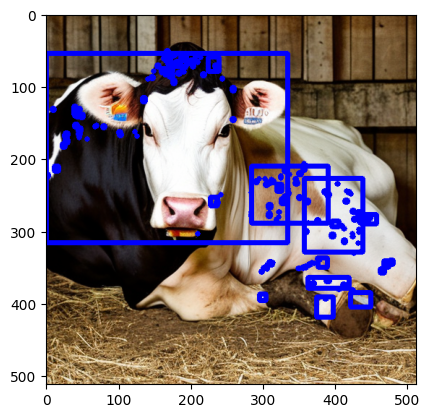

In [48]:
draw_boxes(img, boxes)

[([0, 54, 334, 316], 88105), ([284, 210, 390, 289], 8560), ([357, 227, 438, 329], 8446), ([362, 364, 419, 379], 928), ([374, 391, 397, 419], 696), ([421, 385, 449, 405], 609), ([224, 59, 239, 79], 336)]
6


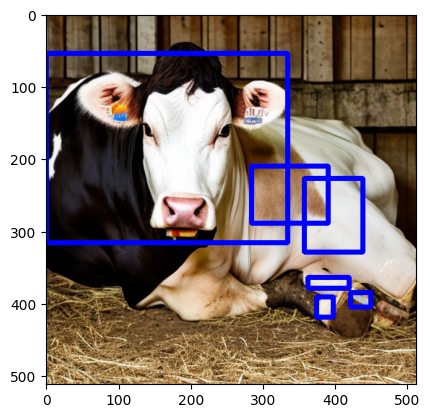

In [57]:
boxes2 = nms_boxes(boxes, min_area=16**2)
print(len(boxes2))
draw_boxes(img, boxes2)

1


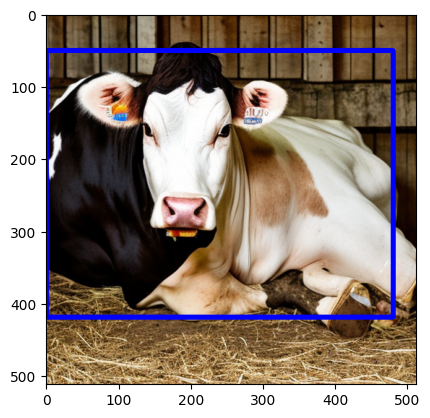

In [77]:
boxes4 = combine_boxes(boxes)
print(len(boxes4))
draw_boxes(img, boxes4)

In [39]:
model, preprocess = clip.load("ViT-L/14@336px")
model.cuda().eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)


In [40]:
text_feature_getter = TextFeatureFixed(model)
img_feature_getter = ImageFeatureBoxes(model, preprocess)


100%|██████████| 25/25 [00:01<00:00, 20.02it/s]


In [51]:
image_features = img_feature_getter.get_img_feature(img_path, ann_path)
text_features = text_feature_getter.get_text_feature()
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
text_probs = text_probs.cpu().numpy()

In [42]:
all_names = VOC_NEW + VOC_BACKGROUND_CATEGORY

In [52]:
for bid, box_probs in enumerate(text_probs):
    print(f"box {bid}")
    for i, p in enumerate(box_probs):
        print(f"{all_names[i]:<12}: {p*100:.4}")

box 0
aeroplane   : 0.0007808
bicycle     : 3.576e-05
bird avian  : 0.0001192
boat        : 0.0001729
bottle      : 0.001949
bus         : 0.00239
car         : 0.0004947
cat         : 0.0002801
chair seat  : 0.000751
cow         : 99.8
diningtable : 0.0007391
dog         : 0.001144
horse       : 0.01835
motorbike   : 5.96e-05
person with clothes,people,human: 0.0001907
pottedplant : 0.0001431
sheep       : 0.07606
sofa        : 0.007832
train       : 0.0006437
tvmonitor screen: 0.04134
ground      : 0.0004947
land        : 0.001627
grass       : 0.0009
tree        : 1.192e-05
building    : 0.0004947
wall        : 0.0003695
sky         : 0.0004828
lake        : 2.98e-05
water       : 0.0001132
river       : 1.192e-05
sea         : 5.96e-05
railway     : 6.557e-05
railroad    : 5.96e-05
keyboard    : 0.01139
helmet      : 0.000906
cloud       : 0.006801
house       : 0.0006557
mountain    : 9.537e-05
ocean       : 5.96e-05
road        : 4.768e-05
rock        : 0.0003159
street      : 8.